# Step4-XGBoost

## Imports and data

In [203]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.calibration import calibration_curve
import wandb
import itertools
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import os
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

In [205]:
path_train="../../data/milestone2/advanced_train.csv"
path_figures="../../figures/milestone2/step4-xgboost/"
path_models="../../models/milestone2/"
os.makedirs(path_figures, exist_ok=True)
os.makedirs(path_models, exist_ok=True)

In [206]:
df_train=pd.read_csv(path_train)
df_train.head()

,period_time_seconds,period,x_coord,y_coord,distance_from_net,shot_angle,shot_type,empty_net,last_event_type,last_event_x,...,time_since_last_event,last_event_distance,rebound,angle_change,event_speed,friendly_player_count,opponent_player_count,player_count_diff,time_since_powerplay,is_goal
0,18,1,82.0,10.0,12.206556,55.007980,snap,0,faceoff,0.0,...,18.0,82.607506,False,0.000000,4.589306,5,5,0,0,0
1,58,1,44.0,28.0,53.000000,31.890792,slap,0,hit,42.0,...,9.0,8.246211,False,0.000000,0.916246,5,5,0,0,0
2,180,1,63.0,-29.0,38.948684,48.122130,snap,0,missed-shot,-74.0,...,4.0,141.155942,True,150.312818,35.288986,5,5,0,0,0
3,297,1,62.0,-6.0,27.658633,12.528808,wrist,0,blocked-shot,70.0,...,8.0,9.433981,False,0.000000,1.179248,5,5,0,0,0
4,341,1,31.0,34.0,67.230945,30.379126,wrist,0,giveaway,39.0,...,6.0,35.902646,False,0.000000,5.983774,5,5,0,0,0


In [207]:
df_train.columns

Index(['period_time_seconds', 'period', 'x_coord', 'y_coord',
       'distance_from_net', 'shot_angle', 'shot_type', 'empty_net',
       'last_event_type', 'last_event_x', 'last_event_y',
       'time_since_last_event', 'last_event_distance', 'rebound',
       'angle_change', 'event_speed', 'friendly_player_count',
       'opponent_player_count', 'player_count_diff', 'time_since_powerplay',
       'is_goal'],
      dtype='object')

In [208]:
all_features=['period_time_seconds', 'period', 'x_coord', 'y_coord',
       'distance_from_net', 'shot_angle', 'shot_type', 'empty_net',
       'last_event_type', 'last_event_x', 'last_event_y',
       'time_since_last_event', 'last_event_distance', 'rebound',
       'angle_change', 'event_speed', 'friendly_player_count',
       'opponent_player_count', 'player_count_diff', 'time_since_powerplay']
bool_features=["rebound", "empty_net"]
cat_features=["period", "shot_type", "last_event_type", "player_count_diff",'friendly_player_count','opponent_player_count']
df_train[bool_features] = df_train[bool_features].astype(int)
df_train[cat_features]=df_train[cat_features].astype("category")

In [211]:
print(len(all_features))

20


In [209]:
df_train

,period_time_seconds,period,x_coord,y_coord,distance_from_net,shot_angle,shot_type,empty_net,last_event_type,last_event_x,...,time_since_last_event,last_event_distance,rebound,angle_change,event_speed,friendly_player_count,opponent_player_count,player_count_diff,time_since_powerplay,is_goal
0,18,1,82.0,10.0,12.206556,55.007980,snap,0,faceoff,0.0,...,18.0,82.607506,0,0.000000,4.589306,5,5,0,0,0
1,58,1,44.0,28.0,53.000000,31.890792,slap,0,hit,42.0,...,9.0,8.246211,0,0.000000,0.916246,5,5,0,0,0
2,180,1,63.0,-29.0,38.948684,48.122130,snap,0,missed-shot,-74.0,...,4.0,141.155942,1,150.312818,35.288986,5,5,0,0,0
3,297,1,62.0,-6.0,27.658633,12.528808,wrist,0,blocked-shot,70.0,...,8.0,9.433981,0,0.000000,1.179248,5,5,0,0,0
4,341,1,31.0,34.0,67.230945,30.379126,wrist,0,giveaway,39.0,...,6.0,35.902646,0,0.000000,5.983774,5,5,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316535,856,3,60.0,-1.0,29.017236,1.974934,wrist,0,hit,-61.0,...,26.0,126.530629,0,0.000000,4.866563,5,5,0,0,0
316536,892,3,32.0,20.0,60.406953,19.334809,slap,0,hit,99.0,...,29.0,67.896981,0,0.000000,2.341275,5,5,0,0,0
316537,899,3,64.0,5.0,25.495098,11.309932,wrist,0,giveaway,-95.0,...,25.0,159.012578,0,0.000000,6.360503,5,5,0,0,0
316538,1126,3,42.0,-2.0,47.042534,2.436648,deflected,0,shot-on-goal,-20.0,...,18.0,64.845971,1,165.509135,3.602554,5,5,0,0,0


## Step 4.1 : Baseline

### train model

In [212]:
X = df_train[['distance_from_net', 'shot_angle']]
Y = df_train[["is_goal"]]

In [213]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    Y,
    test_size=0.2,      
    random_state=42
)

We divide the dataset as 80% for training and 20% for validation.

In [214]:
wandb.init(
    project="milestone_2",        
    name="xgb_model1",    
    config={
        "model": "XGBoost",
        "features": "distance and angle",
    }
)

wandb: Currently logged in as: antonios-lagarias (IFT6758_team4) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [215]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val, label=y_val)

In [216]:
# Default params
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'

In [217]:
wandb.config.update(param)

In [218]:
evallist = [(dtrain, 'train'), (dval, 'val')]
num_round = 100
evals_result = {}

model1 = xgb.train(
    params=param,
    dtrain=dtrain,
    num_boost_round=num_round,
    evals=evallist,                  
    early_stopping_rounds=10,
    evals_result=evals_result,
    verbose_eval=False
)

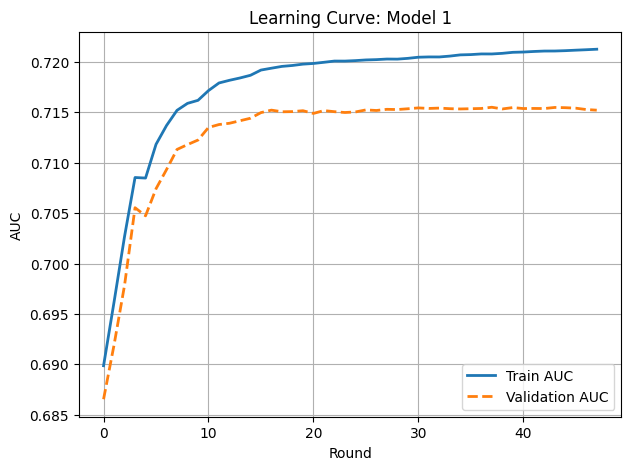

In [219]:
# Plot learning curves
train_auc = evals_result["train"]["auc"]
val_auc   = evals_result["val"]["auc"]
rounds    = np.arange(len(train_auc))

plt.figure(figsize=(7, 5))
plt.plot(rounds, train_auc, label="Train AUC", linewidth=2)
plt.plot(rounds, val_auc,   label="Validation AUC", linewidth=2, linestyle="--")
plt.xlabel("Round")
plt.ylabel("AUC")
plt.title("Learning Curve: Model 1")
plt.legend(loc="lower right")
plt.grid(True)

fig_path = path_figures + "learning_curve_model1.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

In [220]:
best_iteration = model1.best_iteration
train_auc = evals_result["train"]["auc"][best_iteration]
val_auc = evals_result["val"]["auc"][best_iteration]
print(train_auc, val_auc)

0.7207833827514637 0.7154985292784708


In [221]:
wandb.log({
    "train_auc": train_auc,
    "best_iteration": best_iteration,
    "val_auc":val_auc
})

wandb.log({"learning_curve_auc": wandb.Image(fig_path)})

### figures

In [224]:
y_pred = model1.predict(dval)

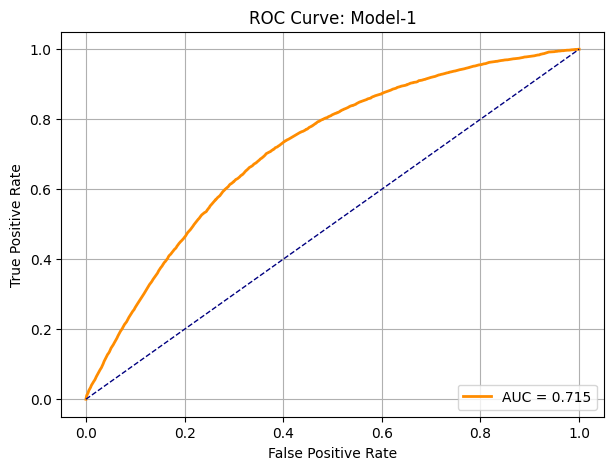

In [225]:
#Compute 
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
# Plot
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Model-1')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig(path_figures+"roc_model1.png", dpi=300)
plt.show()

The ROC curve for the XGBoost model trained on only distance and angle shows an AUC of ~0.71. This indicates that the model can distinguish to some degree higher-quality shots from low-quality ones since it performs better than the 45-angle line.

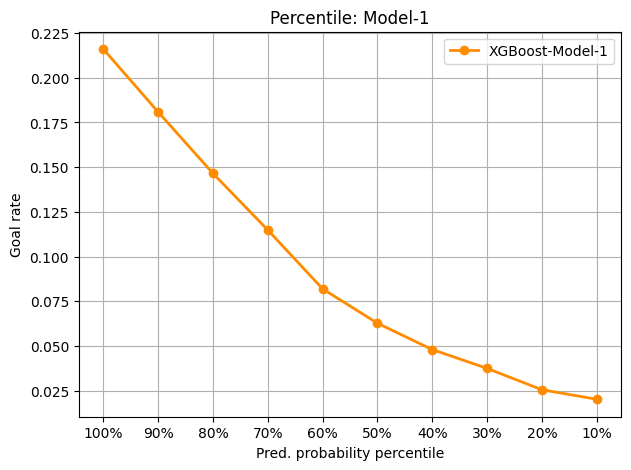

In [226]:
# prepare
df_val = pd.DataFrame({
    "y": np.asarray(y_val).ravel(),
    "p": y_pred

})

df_val["percentile_bin"] = pd.qcut(
    df_val["p"],
    q=10,                 
    labels=False
)

# compute
grouped = df_val.groupby("percentile_bin").agg(
    goal_rate=("y", "mean"),
    mean_prob=("p", "mean"),
    count=("y", "size")
).reset_index()

grouped["percentile_label"] = (grouped["percentile_bin"] + 1) * 10

# plot
plt.figure(figsize=(7, 5))
plt.plot(grouped["percentile_label"], grouped["goal_rate"],
         marker='o', color='darkorange', lw=2, label='XGBoost-Model-1')
plt.xlabel("Pred. probability percentile")
plt.ylabel("Goal rate")
plt.title("Percentile: Model-1")
plt.xticks(grouped["percentile_label"], [f"{x}%" for x in grouped["percentile_label"]])
plt.legend(loc='upper right')
plt.grid(True)
plt.gca().invert_xaxis()

# save
plt.savefig(path_figures + "percentile_model1.png", dpi=300)

plt.show()

The curve looks as expected of a correct model. The actual goal rate increases for shots in bins with higher predicted probability. For instance, among the 10% of shots the model thought were most dangerous, 22.5% were actually goals.

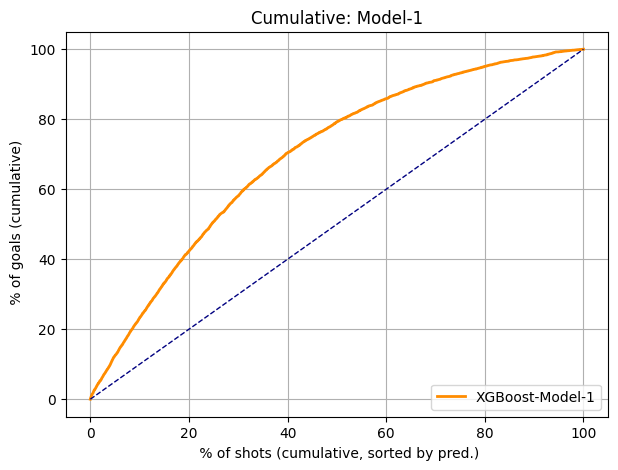

In [227]:
# prepare
df_val = df_val.sort_values("p", ascending=False).reset_index(drop=True)
df_val["cum_shots"] = np.arange(1, len(df_val) + 1)
df_val["cum_goals"] = df_val["y"].cumsum()

df_val["cum_shots_pct"] = df_val["cum_shots"] / len(df_val)
df_val["cum_goals_pct"] = df_val["cum_goals"] / df_val["y"].sum()

# plot
plt.figure(figsize=(7, 5))

plt.plot(df_val["cum_shots_pct"] * 100, df_val["cum_goals_pct"] * 100,
         color='darkorange', lw=2, label='XGBoost-Model-1')

plt.plot([0, 100], [0, 100], color='navy', lw=1, linestyle='--', label='')

plt.xlabel(" % of shots (cumulative, sorted by pred.)")
plt.ylabel(" % of goals (cumulative)")
plt.title("Cumulative: Model-1")
plt.legend(loc='lower right')
plt.grid(True)

# save
plt.savefig(path_figures + "cumulative_model1.png", dpi=300)

plt.show()

The top 20% of shots by predicted xG account for 41% of all goals. The top 40% of shots by predicted xG account for 70% of all goals.

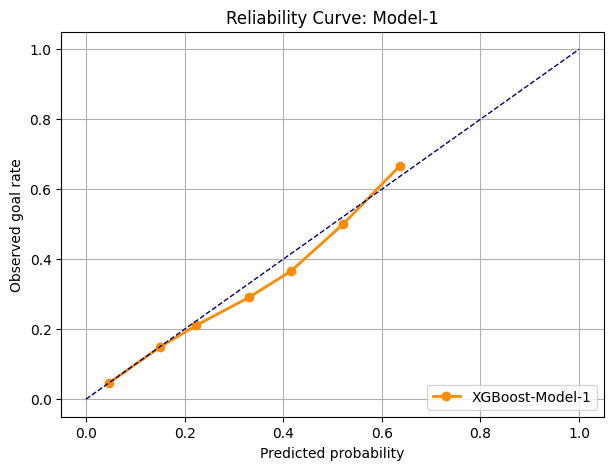

In [228]:
# compute
prob_true, prob_pred = calibration_curve(y_val, y_pred, n_bins=10)

#plot
plt.figure(figsize=(7, 5))
plt.plot(prob_pred, prob_true, marker='o', color='darkorange', lw=2, label='XGBoost-Model-1')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='')
plt.xlabel("Predicted probability")
plt.ylabel("Observed goal rate")
plt.title("Reliability Curve: Model-1")
plt.legend(loc='lower right')
plt.grid(True)

#save
plt.savefig(path_figures + "calibration_model1.png", dpi=300)
plt.show()

This is not ideal.

In [229]:
wandb.finish()

best_iteration,▁
train_auc,▁
val_auc,▁
best_iteration,37
train_auc,0.72078
val_auc,0.7155


## Step 4.2

### Model2A (only numerical data)

### train model

##### Prepare features

##### Check missing values

In [230]:
df_train.isna().sum()

period_time_seconds          0
period                       0
x_coord                     16
y_coord                     15
distance_from_net           17
shot_angle                  17
shot_type                   30
empty_net                    0
last_event_type              8
last_event_x             55264
last_event_y             55258
time_since_last_event        8
last_event_distance      55272
rebound                      0
angle_change                 0
event_speed                  7
friendly_player_count        0
opponent_player_count        0
player_count_diff            0
time_since_powerplay         0
is_goal                      0
dtype: int64

In [231]:
missing_like = ["NA", "N/A", "", "na", "NaN", "None", "null", "NULL"]
df_train.isin(missing_like).sum()[lambda x: x > 0]

Series([], dtype: int64)

In [317]:
model2A_features = [f for f in all_features if f not in cat_features]
print(model2A_features)

X = df_train[model2A_features]
Y = df_train[["is_goal"]]

['period_time_seconds', 'x_coord', 'y_coord', 'distance_from_net', 'shot_angle', 'empty_net', 'last_event_x', 'last_event_y', 'time_since_last_event', 'last_event_distance', 'rebound', 'angle_change', 'event_speed', 'time_since_powerplay']


In [318]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    Y,
    test_size=0.2,      
    random_state=42
)

In [319]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val, label=y_val)

##### Optimize params with grid+cross validation

In [320]:
base_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "tree_method": "hist", 
    "nthread": 8,
    "seed": 42
}

In [236]:
max_depth_grid        = [4,5,6]
learning_rate_grid    = [0.05, 0.075, 0.1]
min_child_weight_grid = [1, 5]
subsample_grid        = [0.8, 0.9, 1.0]
colsample_bytree_grid = [0.8, 0.9, 1.0]

In [237]:
results = [] 

for max_depth, eta, min_child_weight, subsample, colsample_bytree in itertools.product(
    max_depth_grid,
    learning_rate_grid,
    min_child_weight_grid,
    subsample_grid,
    colsample_bytree_grid
):
    params = base_params.copy()
    params.update({
        "max_depth": max_depth,
        "eta": eta,
        "min_child_weight": min_child_weight,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree
    })
    
    cv_result = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=150,       
        nfold=5,                   
        stratified=True,
        metrics="auc",
        early_stopping_rounds=20,
        seed=42,
        verbose_eval=False
    )
    
    # best mean validation AUC and iteration
    best_auc = cv_result["test-auc-mean"].max()
    best_round = cv_result["test-auc-mean"].idxmax()
    
    results.append({
        "max_depth": max_depth,
        "eta": eta,
        "min_child_weight": min_child_weight,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "best_auc": best_auc,
        "best_round": best_round
    })

# collect
results_df = pd.DataFrame(results)

In [238]:
best_row_2A = results_df.loc[results_df["best_auc"].idxmax()]

In [239]:
print(best_row_2A)

max_depth             6.000000
eta                   0.050000
min_child_weight      5.000000
subsample             0.900000
colsample_bytree      0.900000
best_auc              0.820391
best_round          149.000000
Name: 121, dtype: float64


For model2A We run cross-validation with a grid of parameters three time, each time changing the values in the grid. First, a 3-fold CV gave us the best configuration as (max_depth=5, eta=0.1, min_child_weight=5, subsample=1.0, colsample_bytree=0.8). A second 5-fold CV gave us (max_depth=5, eta=0.075, min_child_weight=5, subsample=0.9, colsample_bytree=0.9). The thrird 5-fold CV gave us (max_depth=6, eta=0.05, min_child_weight=5, subsample=0.9, colsample_bytree=0.9) with an AUC of 0.82 (149 rounds) which we kept for training.

In [321]:
best_params = base_params.copy()
best_params.update({
    "max_depth": int(best_row_2A["max_depth"]),
    "eta": best_row_2A["eta"],
    "min_child_weight": best_row_2A["min_child_weight"],
    "subsample": best_row_2A["subsample"],
    "colsample_bytree": best_row_2A["colsample_bytree"]
})

best_num_boost_round = int(best_row_2A["best_round"])

In [322]:
wandb.init(
    project="milestone_2", 
    name="xgb_model2A",    
    config={
        "model": "XGBoost",
        "features": "only numeric",
        ** best_params
    }
)

In [328]:
evallist = [(dtrain, 'train'), (dval, 'val')]
evals_result_2A = {}

model2A = xgb.train(
    params=best_params,
    dtrain=dtrain,
    num_boost_round=best_num_boost_round,
    evals=evallist,
    evals_result=evals_result_2A,
    verbose_eval=False
)

In [ ]:
wandb.config.update(best_params, allow_val_change=True)

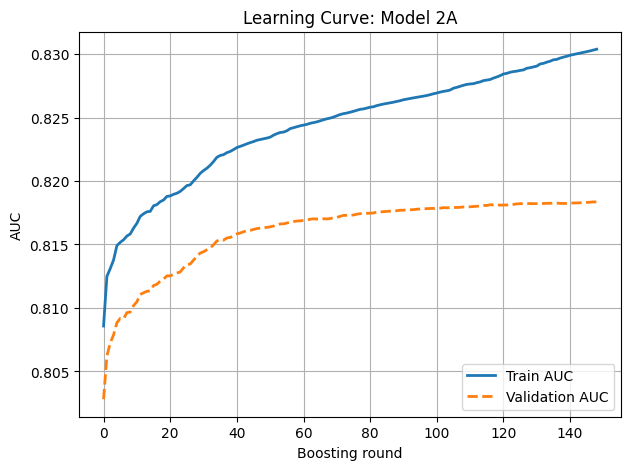

In [329]:
# compute
train_auc = evals_result_2A["train"]["auc"]
val_auc   = evals_result_2A["val"]["auc"]
rounds    = np.arange(len(train_auc))

# plot
plt.figure(figsize=(7, 5))
plt.plot(rounds, train_auc, label="Train AUC", linewidth=2)
plt.plot(rounds, val_auc,   label="Validation AUC", linewidth=2, linestyle="--")
plt.xlabel("Boosting round")
plt.ylabel("AUC")
plt.title("Learning Curve: Model 2A")
plt.legend(loc="lower right")
plt.grid(True)

# save
fig_path = path_figures + "learning_curve_model2A.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

In [330]:
num_rounds = len(evals_result_2A["train"]["auc"]) 
best_iteration = num_rounds - 1

train_auc = evals_result_2A["train"]["auc"][best_iteration]
val_auc = evals_result_2A["val"]["auc"][best_iteration]
print(train_auc)
print(val_auc)

0.8303794264998238
0.8183453264696419


In [249]:
wandb.log({
    "train_auc": train_auc,
    "best_iteration": best_iteration,
    "val_auc":val_auc
})

wandb.log({"learning_curve_auc": wandb.Image(fig_path)})

In [250]:
model_path = path_models+"model2A.ubj"
model2A.save_model(model_path)

# Create artifact
artifact = wandb.Artifact(
    name="xgboost_model2A",
    type="model",
    metadata={
        "description": "XGBoost Model 2B – includes categorical features",
        **best_params, 
        "best_auc_cv": float(best_auc),
        "best_round": int(best_iteration)
    }
)

artifact.add_file(model_path)
wandb.log_artifact(artifact)

<Artifact xgboost_model2A>

### figures

In [251]:
y_pred = model2A.predict(dval)

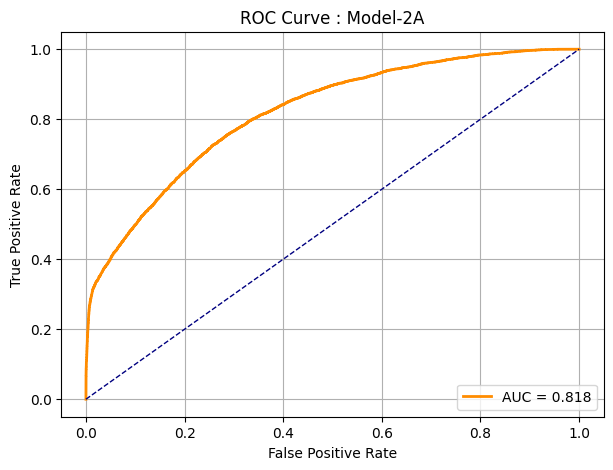

In [252]:
#compute 
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
# plot
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve : Model-2A')
plt.legend(loc='lower right')
plt.grid(True)
#save
plt.savefig(path_figures+"roc_model2A.png", dpi=300)
plt.show()

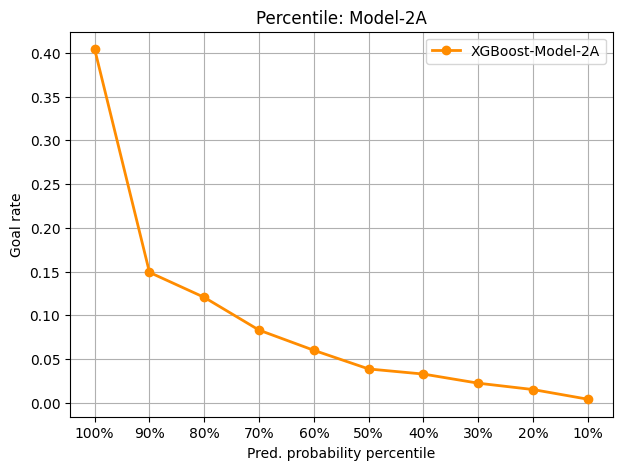

In [253]:
# compute
df_val = pd.DataFrame({
    "y": np.asarray(y_val).ravel(),
    "p": y_pred

})

df_val["percentile_bin"] = pd.qcut(
    df_val["p"],
    q=10,                 
    labels=False
)

grouped = df_val.groupby("percentile_bin").agg(
    goal_rate=("y", "mean"),
    mean_prob=("p", "mean"),
    count=("y", "size")
).reset_index()


grouped["percentile_label"] = (grouped["percentile_bin"] + 1) * 10

# plot
plt.figure(figsize=(7, 5))
plt.plot(grouped["percentile_label"], grouped["goal_rate"],
         marker='o', color='darkorange', lw=2, label='XGBoost-Model-2A')
plt.xlabel("Pred. probability percentile")
plt.ylabel("Goal rate")
plt.title("Percentile: Model-2A")
plt.xticks(grouped["percentile_label"], [f"{x}%" for x in grouped["percentile_label"]])
plt.legend(loc='upper right')
plt.grid(True)
plt.gca().invert_xaxis()

#save
plt.savefig(path_figures + "percentile_model2A.png", dpi=300)

plt.show()

The curve looks as expected of a correct model. The actual goal rate increases for shots in bins with higher predicted probability. For instance, among the 10% of shots the model thought were most dangerous, appr. 40% were actually goals. This is a great improvement to the baseline model.

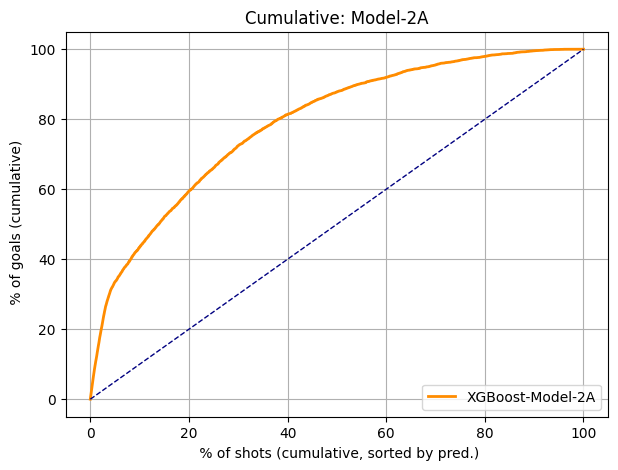

In [254]:
#compute
df_val = df_val.sort_values("p", ascending=False).reset_index(drop=True)
df_val["cum_shots"] = np.arange(1, len(df_val) + 1)
df_val["cum_goals"] = df_val["y"].cumsum()

df_val["cum_shots_pct"] = df_val["cum_shots"] / len(df_val)
df_val["cum_goals_pct"] = df_val["cum_goals"] / df_val["y"].sum()

#plot
plt.figure(figsize=(7, 5))


plt.plot(df_val["cum_shots_pct"] * 100, df_val["cum_goals_pct"] * 100,
         color='darkorange', lw=2, label='XGBoost-Model-2A')

plt.plot([0, 100], [0, 100], color='navy', lw=1, linestyle='--', label='')

plt.xlabel(" % of shots (cumulative, sorted by pred.)")
plt.ylabel(" % of goals (cumulative)")
plt.title("Cumulative: Model-2A")
plt.legend(loc='lower right')
plt.grid(True)

#save
plt.savefig(path_figures + "cumulative_model2A.png", dpi=300)

plt.show()

The top 20% of shots by predicted by XG account for 60% of all goals. The top 40% of shots by predicted xG account for 81% of all goals. This is a slight increase to the baseline model.

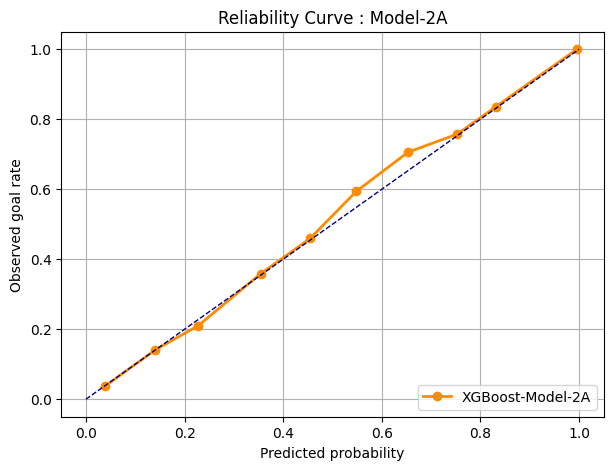

In [255]:
#compute
prob_true, prob_pred = calibration_curve(y_val, y_pred, n_bins=10)
#plot
plt.figure(figsize=(7, 5))
plt.plot(prob_pred, prob_true, marker='o', color='darkorange', lw=2, label='XGBoost-Model-2A')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='')
plt.xlabel("Predicted probability")
plt.ylabel("Observed goal rate")
plt.title("Reliability Curve : Model-2A")
plt.legend(loc='lower right')
plt.grid(True)
#save
plt.savefig(path_figures + "calibration_model2A.png", dpi=300)

plt.show()

This is great.

In [256]:
wandb.finish()

best_iteration,▁
train_auc,▁
val_auc,▁
best_iteration,148
train_auc,0.83038
val_auc,0.81835


### Model 2B (includes categorical features)

### train model

In [257]:
X = df_train[all_features]
Y = df_train[["is_goal"]]

In [258]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    Y,
    test_size=0.2,      
    random_state=42
)

In [259]:
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True) 
dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)

In [260]:
max_depth_grid        = [5, 6]
learning_rate_grid    = [0.05, 0.075, 0.1]
min_child_weight_grid = [1, 5]
subsample_grid        = [0.9, 1.0]
colsample_bytree_grid = [0.8, 0.9]

In [261]:
results = []

for max_depth, eta, min_child_weight, subsample, colsample_bytree in itertools.product(
    max_depth_grid,
    learning_rate_grid,
    min_child_weight_grid,
    subsample_grid,
    colsample_bytree_grid
):
    params = base_params.copy()
    params.update({
        "max_depth": max_depth,
        "eta": eta,
        "min_child_weight": min_child_weight,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree
    })
    
    cv_result = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=150,       # max trees to try
        nfold=5,                   # 5-fold CV
        stratified=True,
        metrics="auc",
        early_stopping_rounds=20,
        seed=42,
        verbose_eval=False
    )
    
    # Best mean validation AUC and the iteration where it happened
    best_auc = cv_result["test-auc-mean"].max()
    best_round = cv_result["test-auc-mean"].idxmax()
    
    results.append({
        "max_depth": max_depth,
        "eta": eta,
        "min_child_weight": min_child_weight,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "best_auc": best_auc,
        "best_round": best_round
    })

# Collect everything in a DataFrame for analysis/plots
results_df = pd.DataFrame(results)

In [262]:
best_row_2B = results_df.loc[results_df["best_auc"].idxmax()]

In [263]:
print(best_row_2B)

max_depth             6.00000
eta                   0.05000
min_child_weight      1.00000
subsample             1.00000
colsample_bytree      0.80000
best_auc              0.86766
best_round          149.00000
Name: 26, dtype: float64


For model2B we started from the previous best parameters, and adjusted the grid to see if there is any change. We run a single cross-validation that gave us the best configuration as (max_depth=6, eta=0.05, min_child_weight=1, subsample=1.0, colsample_bytree=0.8) with an AUC of 0.867 (149 rounds).

In [264]:
best_params = base_params.copy()
best_params.update({
    "max_depth": int(best_row_2B["max_depth"]),
    "eta": best_row_2B["eta"],
    "min_child_weight": best_row_2B["min_child_weight"],
    "subsample": best_row_2B["subsample"],
    "colsample_bytree": best_row_2B["colsample_bytree"]
})

best_num_boost_round = int(best_row_2B["best_round"])

In [265]:
wandb.init(
    project="milestone_2", 
    name="xgb_model2B",    
    config={
        "model": "XGBoost",
        "features": "all_features",
        **best_params
    }
)

In [269]:
evallist = [(dtrain, 'train'), (dval, 'val')]
evals_result_2B = {}

model2B = xgb.train(
    params=best_params,
    dtrain=dtrain,
    num_boost_round=best_num_boost_round+20,
    evals=evallist,
    evals_result=evals_result_2B,
    verbose_eval=False
)

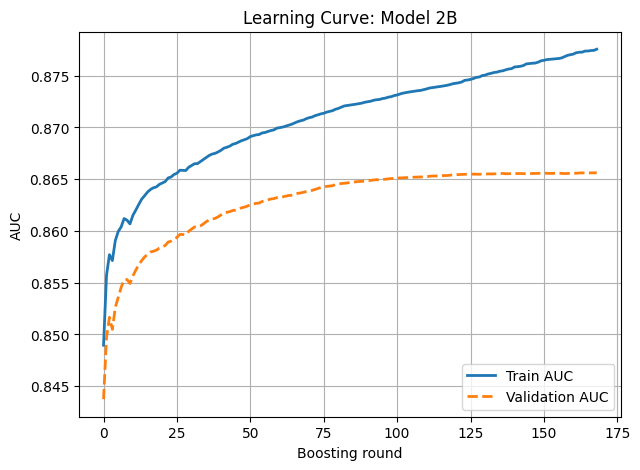

In [270]:
train_auc = evals_result_2B["train"]["auc"]
val_auc   = evals_result_2B["val"]["auc"]
rounds    = np.arange(len(train_auc))

# 2. Plot learning curves
plt.figure(figsize=(7, 5))
plt.plot(rounds, train_auc, label="Train AUC", linewidth=2)
plt.plot(rounds, val_auc,   label="Validation AUC", linewidth=2, linestyle="--")
plt.xlabel("Boosting round")
plt.ylabel("AUC")
plt.title("Learning Curve: Model 2B")
plt.legend(loc="lower right")
plt.grid(True)

# 3. Save figure locally
fig_path = path_figures + "learning_curve_model2B.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

In [271]:
num_rounds = len(evals_result_2B["train"]["auc"]) 
best_iteration = num_rounds - 1

train_auc = evals_result_2B["train"]["auc"][best_iteration]
val_auc = evals_result_2B["val"]["auc"][best_iteration]

print(train_auc)
print(val_auc)

0.8775504020612033
0.8656164280544563


In [272]:
wandb.log({
    "train_auc": train_auc,
    "best_iteration": best_iteration,
    "val_auc":val_auc
})

In [273]:
wandb.log({"learning_curve": wandb.Image(fig_path)})

In [274]:
model_path = path_models+"model2B.ubj"
model2B.save_model(model_path)

In [275]:
# Create artifact
artifact = wandb.Artifact(
    name="xgboost_model2B",
    type="model",
    metadata={
        "description": "XGBoost Model 2B – includes categorical features",
        **best_params, 
        "best_auc_cv": float(best_auc),
        "best_round": int(best_iteration)
    }
)

artifact.add_file(model_path)
wandb.log_artifact(artifact)

<Artifact xgboost_model2B>

### figures

In [276]:
y_pred = model2B.predict(dval)

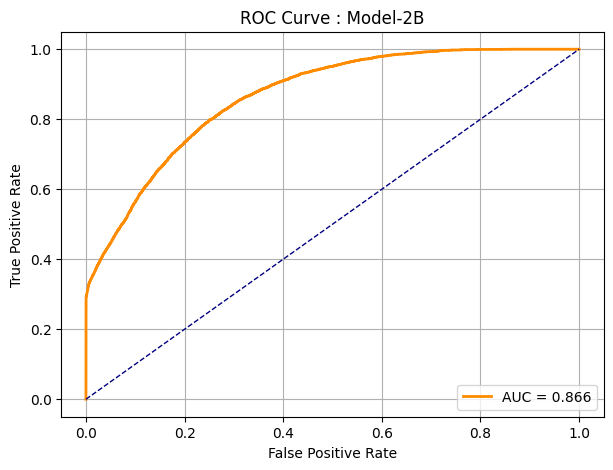

In [277]:
#Compute 
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
# Plot
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve : Model-2B')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig(path_figures+"roc_model2B.png", dpi=300)
plt.show()

   percentile_bin  goal_rate  mean_prob  count  percentile_label
9               9   0.441636   0.444644   6331               100


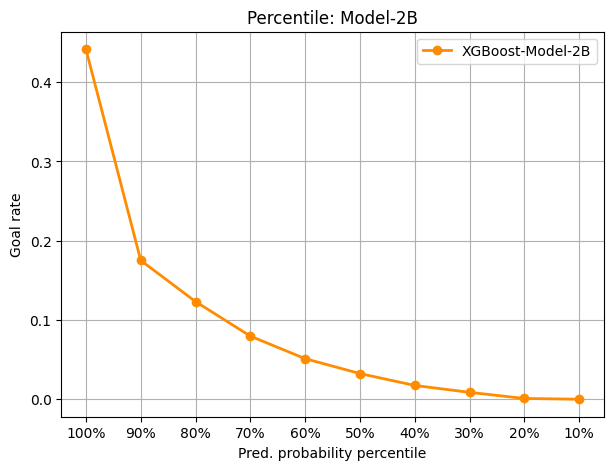

In [278]:
# Compute
df_val = pd.DataFrame({
    "y": np.asarray(y_val).ravel(),
    "p": y_pred

})

df_val["percentile_bin"] = pd.qcut(
    df_val["p"],
    q=10,                 
    labels=False
)

grouped = df_val.groupby("percentile_bin").agg(
    goal_rate=("y", "mean"),
    mean_prob=("p", "mean"),
    count=("y", "size")
).reset_index()

grouped["percentile_label"] = (grouped["percentile_bin"] + 1) * 10

# plot
plt.figure(figsize=(7, 5))
plt.plot(grouped["percentile_label"], grouped["goal_rate"],
         marker='o', color='darkorange', lw=2, label='XGBoost-Model-2B')
plt.xlabel("Pred. probability percentile")
plt.ylabel("Goal rate")
plt.title("Percentile: Model-2B")
plt.xticks(grouped["percentile_label"], [f"{x}%" for x in grouped["percentile_label"]])
plt.legend(loc='upper right')
plt.grid(True)
plt.gca().invert_xaxis()
print(grouped[grouped["percentile_bin"] == grouped["percentile_bin"].max()])
# Save
plt.savefig(path_figures + "percentile_model2B.png", dpi=300)

plt.show()

Better performance compared to model2A

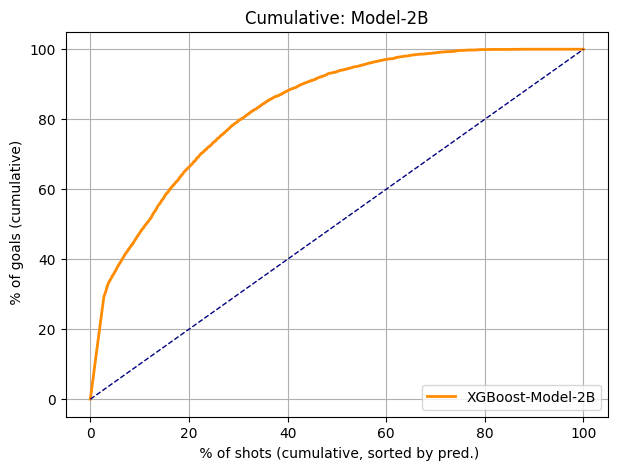

In [279]:
# compute
df_val = df_val.sort_values("p", ascending=False).reset_index(drop=True)
df_val["cum_shots"] = np.arange(1, len(df_val) + 1)
df_val["cum_goals"] = df_val["y"].cumsum()


df_val["cum_shots_pct"] = df_val["cum_shots"] / len(df_val)
df_val["cum_goals_pct"] = df_val["cum_goals"] / df_val["y"].sum()

# plot
plt.figure(figsize=(7, 5))

plt.plot(df_val["cum_shots_pct"] * 100, df_val["cum_goals_pct"] * 100,
         color='darkorange', lw=2, label='XGBoost-Model-2B')


plt.plot([0, 100], [0, 100], color='navy', lw=1, linestyle='--', label='')

plt.xlabel(" % of shots (cumulative, sorted by pred.)")
plt.ylabel(" % of goals (cumulative)")
plt.title("Cumulative: Model-2B")
plt.legend(loc='lower right')
plt.grid(True)

#save
plt.savefig(path_figures + "cumulative_model2B.png", dpi=300)

plt.show()

Improvement to model2A

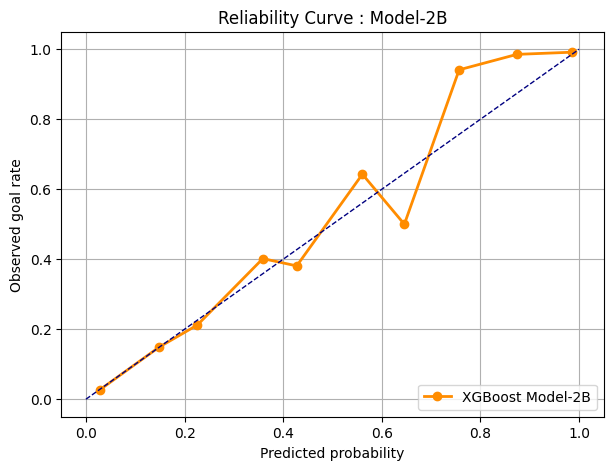

In [280]:
# compute
prob_true, prob_pred = calibration_curve(y_val, y_pred, n_bins=10)
#plot
plt.figure(figsize=(7, 5))
plt.plot(prob_pred, prob_true, marker='o', color='darkorange', lw=2, label='XGBoost Model-2B')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='')
plt.xlabel("Predicted probability")
plt.ylabel("Observed goal rate")
plt.title("Reliability Curve : Model-2B")
plt.legend(loc='lower right')
plt.grid(True)
# save
plt.savefig(path_figures + "calibration_model2B.png", dpi=300)

plt.show()

Here, model 2B performs a bit worse compared to model 2A.

In [326]:
wandb.finish()

## Step 4.3

### information theory filtering

#### information gain

In [335]:
X = df_train[model2A_features]
Y = df_train[["is_goal"]]

In [336]:
imputer = SimpleImputer(strategy="most_frequent")
X.loc[:, "rebound"] = imputer.fit_transform(X[["rebound"]])

imputer = SimpleImputer(strategy="mean")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

In [337]:
mi_scores = mutual_info_classif(X, Y.values.ravel(), random_state=42)

In [338]:
feature_cols = X.columns

mi_gain_df = pd.DataFrame({
    "feature": feature_cols,
    "mi_score": mi_scores
})

mi_gain_df.sort_values(by="mi_score", ascending=False)

,feature,mi_score
9,last_event_distance,0.023960
3,distance_from_net,0.022452
8,time_since_last_event,0.018821
2,y_coord,0.018155
1,x_coord,0.016009
4,shot_angle,0.015956
12,event_speed,0.012491
5,empty_net,0.011233
7,last_event_y,0.004741
10,rebound,0.004572


#### mutual information

In [339]:
#test
f1 = "distance_from_net"
f2 = "x_coord"

mi_value = mutual_info_regression(
    X[[f1]],  # X must be 2D (feature matrix)
    X[f2],    # y must be 1D (target vector)
    random_state=42
)[0]

print(f"Mutual information between {f1} and {f2}: {mi_value:.4f}")

Mutual information between distance_from_net and x_coord: 3.5110


In [340]:
n_features = len(feature_cols)
mi_matrix = np.zeros((n_features, n_features))

for i, f1 in enumerate(feature_cols):
    for j, f2 in enumerate(feature_cols):
        if j <= i:
            continue 
        mi_value = mutual_info_regression(
            X[[f1]],   
            X[f2],     
            random_state=42
        )[0]
        mi_matrix[i, j] = mi_matrix[j, i] = mi_value

# turn into a DataFrame
mi_df = pd.DataFrame(mi_matrix, index=feature_cols, columns=feature_cols)

In [100]:
mi_df

,period_time_seconds,x_coord,y_coord,distance_from_net,shot_angle,empty_net,last_event_x,last_event_y,time_since_last_event,last_event_distance,rebound,angle_change,event_speed,friendly_player_count,opponent_player_count,time_since_powerplay
period_time_seconds,0.000000,0.006849,0.007458,0.008556,0.008255,0.009873,0.049676,0.035236,0.077417,0.020903,0.004645,0.004220,0.021536,0.004401,0.008449,0.028991
x_coord,0.006849,0.000000,0.127748,3.511225,3.135125,0.003615,0.052154,0.004432,0.004040,0.346063,0.000240,0.014946,0.022357,0.000758,0.000000,0.002393
y_coord,0.007458,0.127748,0.000000,2.786346,2.581976,0.000000,0.002401,0.036907,0.004372,0.202681,0.000179,0.014359,0.011972,0.000000,0.000000,0.000000
distance_from_net,0.008556,3.511225,2.786346,0.000000,5.827783,0.003694,0.036691,0.024525,0.006786,0.566788,0.000208,0.012786,0.019134,0.003598,0.000995,0.001736
shot_angle,0.008255,3.135125,2.581976,5.827783,0.000000,0.001962,0.028427,0.021043,0.005114,0.490196,0.000905,0.063692,0.011888,0.001007,0.000368,0.001375
empty_net,0.009873,0.003615,0.000000,0.003694,0.001962,0.000000,0.000000,0.001445,0.000271,0.000388,0.000732,0.000699,0.000070,0.000000,0.000000,0.000000
last_event_x,0.049676,0.052154,0.002401,0.036691,0.028427,0.000000,0.000000,0.938198,0.066305,1.211732,0.087110,0.188543,0.528360,0.003361,0.009967,0.057807
last_event_y,0.035236,0.004432,0.036907,0.024525,0.021043,0.001445,0.938198,0.000000,0.059934,0.576390,0.075467,0.085946,0.366764,0.002362,0.006881,0.042752
time_since_last_event,0.077417,0.004040,0.004372,0.006786,0.005114,0.000271,0.066305,0.059934,0.000000,0.128612,0.002304,0.024662,1.207063,0.002200,0.002115,0.031394
last_event_distance,0.020903,0.346063,0.202681,0.566788,0.490196,0.000388,1.211732,0.576390,0.128612,0.000000,0.039101,0.119227,2.945407,0.000283,0.004729,0.007974


In [119]:
mask = np.triu(np.ones(mi_df.shape), k=1).astype(bool)
upper_tri = mi_df.where(mask)
stacked = upper_tri.stack()
redundant_pairs = stacked.reset_index()
redundant_pairs.columns = ["feature_1", "feature_2", "mi"]

In [120]:
redundant_pairs.sort_values("mi", ascending=False).head(15)

,feature_1,feature_2,mi
36,distance_from_net,shot_angle,5.827783
14,x_coord,distance_from_net,3.511225
15,x_coord,shot_angle,3.135125
83,last_event_distance,event_speed,2.945407
25,y_coord,distance_from_net,2.786346
26,y_coord,shot_angle,2.581976
65,last_event_x,last_event_distance,1.211732
79,time_since_last_event,event_speed,1.207063
63,last_event_x,last_event_y,0.938198
71,last_event_y,last_event_distance,0.576390


In [287]:
strong_features = ["last_event_distance", "time_since_last_event", "distance_from_net", "empty_net", "rebound"]

In [288]:
weak_features= ["angle_change", "period_time_seconds", "time_since_powerplay"]

In [289]:
redudant_features= ["y_coord", "x_coord","last_event_x", "last_event_y" ]

In [290]:
candidate_features = ["shot_angle", "event_speed"]

In [291]:
print(cat_features)

['period', 'shot_type', 'last_event_type', 'player_count_diff', 'friendly_player_count', 'opponent_player_count']


### forward wrapper

In [292]:
best_params = base_params.copy()
best_params.update({
    "max_depth": int(best_row_2B["max_depth"]),
    "eta": best_row_2B["eta"],
    "min_child_weight": best_row_2B["min_child_weight"],
    "subsample": best_row_2B["subsample"],
    "colsample_bytree": best_row_2B["colsample_bytree"]
})

best_num_boost_round = int(best_row_2B["best_round"])

In [294]:
def evaluate_features(feature_list, X_train, y_train, X_val, y_val, params, num_boost_round=100):
    
    dtrain = xgb.DMatrix(X_train[feature_list], label=y_train, enable_categorical=True)
    dval = xgb.DMatrix(X_val[feature_list], label=y_val, enable_categorical=True)
    
    model = xgb.train(
        params=best_params,
        dtrain=dtrain,
        num_boost_round=200,
        verbose_eval=False
    )
    
    preds = model.predict(dval)
    out = roc_auc_score(y_val, preds)
    return out

In [295]:
final_features=strong_features+['period', 'shot_type', 'last_event_type', 'player_count_diff']

In [296]:
X = df_train[all_features]
Y = df_train[["is_goal"]]

X_train, X_val, y_train, y_val = train_test_split(
    X,
    Y,
    test_size=0.2,      
    random_state=42
)

can_features = [c for c in all_features if c not in final_features]
baseline_features = final_features

# -- Evaluate baseline
best_auc = evaluate_features(baseline_features, X_train, y_train, X_val, y_val, best_params)
print(f"\nBaseline AUC (with {len(baseline_features)} features): {best_auc:.4f}\n")

# -- Evaluate each candidate (only one each time - I ignore combinations for this)
results = []
for feat in can_features:
    test_features = strong_features + [feat]
    test_auc = evaluate_features(test_features, X_train, y_train, X_val, y_val, params)
    delta = test_auc - best_auc
    results.append((feat, test_auc, delta))
    sign = "+" if delta >= 0 else "-"
    print(f"Feature '{feat:20s}' → AUC = {test_auc:.4f} ({sign}{abs(delta):.4f})")

results_df = pd.DataFrame(results, columns=["feature", "val_auc", "delta"])
results_df.sort_values("delta", ascending=False, inplace=True)


Baseline AUC (with 9 features): 0.8592

Feature 'period_time_seconds ' → AUC = 0.8067 (-0.0525)
Feature 'x_coord             ' → AUC = 0.8134 (-0.0457)
Feature 'y_coord             ' → AUC = 0.8136 (-0.0455)
Feature 'shot_angle          ' → AUC = 0.8134 (-0.0457)
Feature 'last_event_x        ' → AUC = 0.8062 (-0.0530)
Feature 'last_event_y        ' → AUC = 0.8049 (-0.0543)
Feature 'angle_change        ' → AUC = 0.8040 (-0.0552)
Feature 'event_speed         ' → AUC = 0.8042 (-0.0550)
Feature 'friendly_player_count' → AUC = 0.8040 (-0.0552)
Feature 'opponent_player_count' → AUC = 0.8042 (-0.0549)
Feature 'time_since_powerplay' → AUC = 0.8043 (-0.0548)


### best params

In [299]:
X = df_train[final_features]
Y = df_train[["is_goal"]]

In [300]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    Y,
    test_size=0.2,      
    random_state=42
)

In [301]:
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True) 
dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)

In [196]:
max_depth_grid        = [4,5,6]
learning_rate_grid    = [0.04, 0.05, 0.06]
min_child_weight_grid = [1, 5]
subsample_grid        = [0.8, 0.9, 1.0]
colsample_bytree_grid = [00.8, 0.9, 1.0]

In [197]:
results = [] 

for max_depth, eta, min_child_weight, subsample, colsample_bytree in itertools.product(
    max_depth_grid,
    learning_rate_grid,
    min_child_weight_grid,
    subsample_grid,
    colsample_bytree_grid
):
    params = base_params.copy()
    params.update({
        "max_depth": max_depth,
        "eta": eta,
        "min_child_weight": min_child_weight,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree
    })
    
    cv_result = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=200,       
        nfold=5,                   
        stratified=True,
        metrics="auc",
        early_stopping_rounds=20,
        seed=42,
        verbose_eval=False
    )
    
    # Best mean validation AUC and the iteration where it happened
    best_auc = cv_result["test-auc-mean"].max()
    best_round = cv_result["test-auc-mean"].idxmax()
    
    results.append({
        "max_depth": max_depth,
        "eta": eta,
        "min_child_weight": min_child_weight,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "best_auc": best_auc,
        "best_round": best_round
    })

# Collect everything
results_df = pd.DataFrame(results)
best_row_3 = results_df.loc[results_df["best_auc"].idxmax()]

In [303]:
print(best_row_3)

max_depth             6.000000
eta                   0.050000
min_child_weight      5.000000
subsample             0.800000
colsample_bytree      1.000000
best_auc              0.860543
best_round          172.000000
Name: 137, dtype: float64


For model3 we started from the previous known best parameters (for model 2B), and adjusted the grid. We run a two cross-validation adjusting the values and resulted in (max_depth=6, eta=0.05, min_child_weight=5, subsample=0.8, colsample_bytree=1.0) with an AUC of 0.86 (173 rounds).

In [304]:
best_params = base_params.copy()
best_params.update({
    "max_depth": int(best_row_3["max_depth"]),
    "eta": best_row_3["eta"],
    "min_child_weight": best_row_3["min_child_weight"],
    "subsample": best_row_3["subsample"],
    "colsample_bytree": best_row_3["colsample_bytree"]
})

best_num_boost_round = int(best_row_3["best_round"])

In [305]:
wandb.init(
    project="milestone_2", 
    name="xgb_model3",    
    config={
        "model": "XGBoost",
        "features": "final_features",
        **best_params
    }
)

In [306]:
evallist = [(dtrain, 'train'), (dval, 'val')]
evals_result_3 = {}

model3 = xgb.train(
    params=best_params,
    dtrain=dtrain,
    num_boost_round=best_num_boost_round,
    evals=evallist,
    evals_result=evals_result_3,
    verbose_eval=False
)

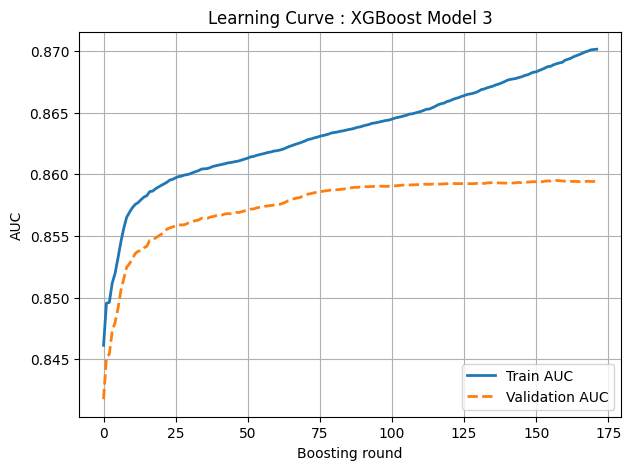

In [307]:
train_auc = evals_result_3["train"]["auc"]
val_auc   = evals_result_3["val"]["auc"]
rounds    = np.arange(len(train_auc))

# plot
plt.figure(figsize=(7, 5))
plt.plot(rounds, train_auc, label="Train AUC", linewidth=2)
plt.plot(rounds, val_auc,   label="Validation AUC", linewidth=2, linestyle="--")
plt.xlabel("Boosting round")
plt.ylabel("AUC")
plt.title("Learning Curve : XGBoost Model 3")
plt.legend(loc="lower right")
plt.grid(True)

# save
fig_path = path_figures + "learning_curve_model3.png"
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

In [308]:
num_rounds = len(evals_result_3["train"]["auc"]) 
best_iteration = num_rounds - 1

train_auc = evals_result_3["train"]["auc"][best_iteration]
val_auc = evals_result_3["val"]["auc"][best_iteration]

print(train_auc)
print(val_auc)

0.8701575406324642
0.8594283744031116


In [309]:
wandb.log({
    "train_auc": train_auc,
    "best_iteration": best_iteration,
    "val_auc":val_auc
})
wandb.log({"learning_curve": wandb.Image(fig_path)})

In [310]:
model_path = path_models+"model3.ubj"
model3.save_model(model_path)

# Create artifact using values from best_params
artifact = wandb.Artifact(
    name="xgboost_model3",
    type="model",
    metadata={
        "description": "XGBoost Model 3 – final features",
        **best_params, 
        "best_auc_cv": float(best_auc),
        "best_round": int(best_iteration)
    }
)

artifact.add_file(model_path)
wandb.log_artifact(artifact)

<Artifact xgboost_model3>

### figures

In [311]:
y_pred = model3.predict(dval)

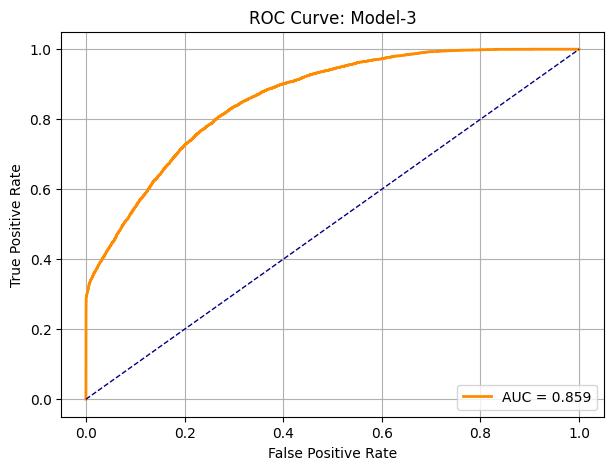

In [312]:
#Compute 
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
# Plot
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Model-3')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig(path_figures+"roc_model3.png", dpi=300)
plt.show()

   percentile_bin  goal_rate  mean_prob  count  percentile_label
9               9   0.435476   0.439129   6331               100


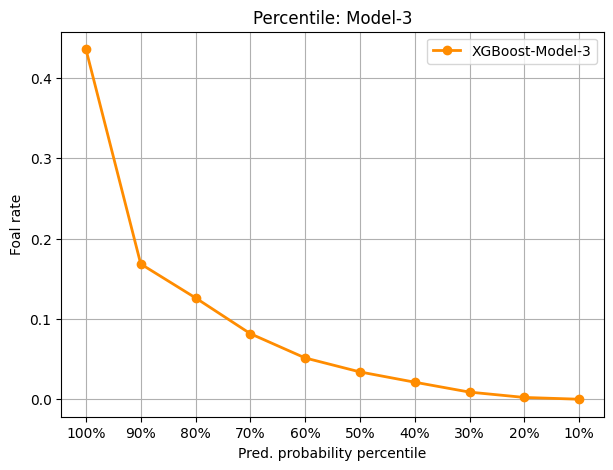

In [313]:
# compute
df_val = pd.DataFrame({
    "y": np.asarray(y_val).ravel(),
    "p": y_pred

})

df_val["percentile_bin"] = pd.qcut(
    df_val["p"],
    q=10,                 
    labels=False
)

grouped = df_val.groupby("percentile_bin").agg(
    goal_rate=("y", "mean"),
    mean_prob=("p", "mean"),
    count=("y", "size")
).reset_index()

grouped["percentile_label"] = (grouped["percentile_bin"] + 1) * 10

# plot
plt.figure(figsize=(7, 5))
plt.plot(grouped["percentile_label"], grouped["goal_rate"],
         marker='o', color='darkorange', lw=2, label='XGBoost-Model-3')
plt.xlabel("Pred. probability percentile")
plt.ylabel("Foal rate")
plt.title("Percentile: Model-3")
plt.xticks(grouped["percentile_label"], [f"{x}%" for x in grouped["percentile_label"]])
plt.legend(loc='upper right')
plt.grid(True)
print(grouped[grouped["percentile_bin"] == grouped["percentile_bin"].max()])
plt.gca().invert_xaxis()

# Save 
plt.savefig(path_figures + "percentile_model3.png", dpi=300)

plt.show()

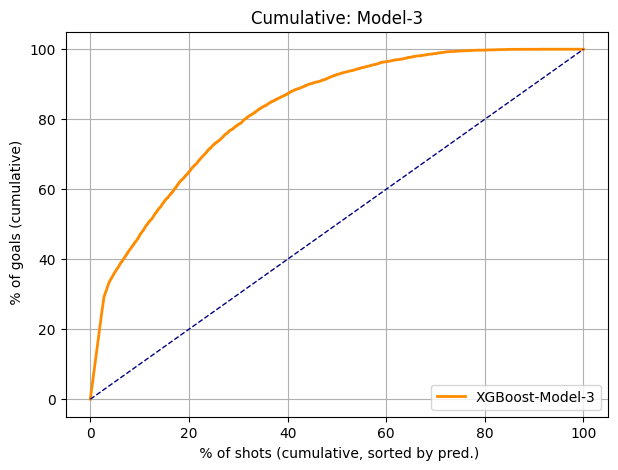

In [314]:
#compute
df_val = df_val.sort_values("p", ascending=False).reset_index(drop=True)
df_val["cum_shots"] = np.arange(1, len(df_val) + 1)
df_val["cum_goals"] = df_val["y"].cumsum()

df_val["cum_shots_pct"] = df_val["cum_shots"] / len(df_val)
df_val["cum_goals_pct"] = df_val["cum_goals"] / df_val["y"].sum()

# plot
plt.figure(figsize=(7, 5))


plt.plot(df_val["cum_shots_pct"] * 100, df_val["cum_goals_pct"] * 100,
         color='darkorange', lw=2, label='XGBoost-Model-3')

plt.plot([0, 100], [0, 100], color='navy', lw=1, linestyle='--', label='')

plt.xlabel(" % of shots (cumulative, sorted by pred.)")
plt.ylabel(" % of goals (cumulative)")
plt.title("Cumulative: Model-3")
plt.legend(loc='lower right')
plt.grid(True)

plt.savefig(path_figures + "cumulative_model3.png", dpi=300)

plt.show()

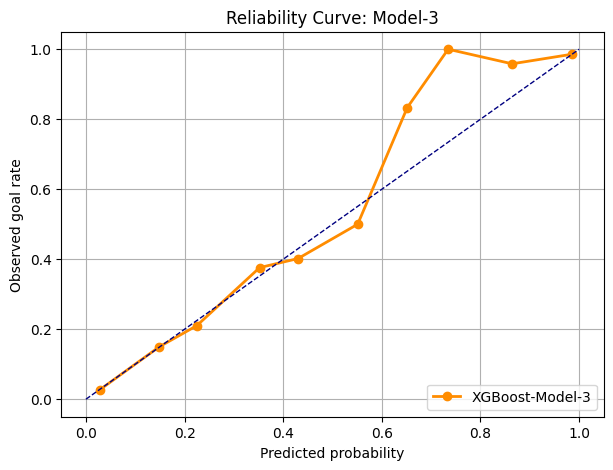

In [315]:
#compute
prob_true, prob_pred = calibration_curve(y_val, y_pred, n_bins=10)
#plot
plt.figure(figsize=(7, 5))
plt.plot(prob_pred, prob_true, marker='o', color='darkorange', lw=2, label='XGBoost-Model-3')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='')
plt.xlabel("Predicted probability")
plt.ylabel("Observed goal rate")
plt.title("Reliability Curve: Model-3")
plt.legend(loc='lower right')
plt.grid(True)
#save
plt.savefig(path_figures + "calibration_model3.png", dpi=300)

plt.show()

In [316]:
wandb.finish()

best_iteration,▁
train_auc,▁
val_auc,▁
best_iteration,171
train_auc,0.87016
val_auc,0.85943


### Disclaimer on the use of LLMs for coding
For the above script, GPT-5 was used on several occassions as a coding assistant. This help took three forms:

Documention on libraries and functions
Prompts were used to quickly obtain information on the arguments required for specific functions. This information is available within the libaries' documentation, but going through LLMs is faster. Example of such propmts are :
"I need store my model as an artifact in wandb. What arguments to use?" 

Specific instructions for challenging coding parts
When unable to proceed alone, I included the logic of what I wanted to achieve in a prompt, and adapted the code based on the response. For instance, in writing the function for the wrapper, the part of the function that assignes evaluates the auc when adding/removing one features was written with the help of a prompt. Similarly, for generating the mi_matrix, I asked for help to mask the highest scoring pairs.

More pretty outputs.
Sometimes I asked to change the f-strings in outputs and add more details, to gain some time.

No original idea was created by GPT 5. We know what our code does and why.